This is the final project . I made few changes and applied GAN model too , in this there are two deep learning model Autoencoder and GAN. Also evaluated using various Evaluation models like Confusion matrix ,accuracy , precision , R2 score , mean absolute error and mean suared error

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
import gc
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import json
import urllib
from datetime import datetime, timedelta,timezone
import requests

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
btc = pd.read_csv('/content/Bitcoin History.csv')
btc.head()

# Data preprocessing


In [ ]:
btc['Date'] = pd.to_datetime(btc.Date, format='%b %d, %Y')
btc.head()

In [ ]:
print('Minutes in dataset: ',len(btc))
print('Hours in dataset: ',len(btc)/60)
print('Days in dataset: ',len(btc)/60/24)

In [ ]:
btc = btc[['Date','Price']]
btc.head()

In [ ]:
btc.info()

In [ ]:
btc['Price'] = pd.to_numeric(btc['Price'], errors='coerce')

btc = btc.resample('H', on='Date')[['Price']].mean()

In [ ]:
    pano = btc.copy()
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pano.index, y=pano['Price'],name='Full history BTC price'))
    fig.update_layout(showlegend=True,title="BTC price history",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
    fig.show()

In [ ]:
import pandas as pd
btc['Price'] = btc['Price'].ffill()

In [ ]:
print('Starting date selected: ',btc.index[51000])
print('NaN values: ',btc.iloc[51000:].isna().sum())

# Data Splitting
We're going to take the test set as the first 20% window. The next 80s as the training set.

In [ ]:
data_for_us = btc.copy()
training_start = int(len(btc) * 0.2)

train = btc.iloc[training_start:]
test = btc.iloc[:training_start]
print("Total datasets' lenght: ",train.shape, test.shape)

# Data scaling



In [ ]:
scaler = MinMaxScaler().fit(train[['Price']])

In [ ]:
def scale_samples(data,column_name,scaler):
    data[column_name] = scaler.transform(data[[column_name]])
    return data

In [ ]:
joblib.dump(scaler, 'scaler.gz')
scaler = joblib.load('scaler.gz')

In [ ]:
train = scale_samples(train.copy(),train.columns[0],scaler)
train.head()

In [ ]:
test = scale_samples(test,test.columns[0],scaler)
test.head()

# Sequences generation and dataset creation

In [ ]:
def shift_samples(data,column_name,lookback=24):
    """This function takes a *data* dataframe and returns two numpy arrays:
    - X corresponds to the same values but packed into n frames of *lookback* values each
    - Y corresponds to the sample shifted *lookback* steps to the future
    """
    data_x = []
    data_y = []
    for i in range(len(data) - int(lookback)):
        x_floats = np.array(data.iloc[i:i+lookback])
        y_floats = np.array(data.iloc[i+lookback])
        data_x.append(x_floats)
        data_y.append(y_floats)
    return np.array(data_x), np.array(data_y)

In [ ]:
X_train, y_train = shift_samples(train[['Price']],train.columns[0])
X_test, y_test = shift_samples(test[['Price']], test.columns[0])
gc.collect()

In [ ]:
print("Final datasets' shapes:")
print('X_train: '+str(X_train.shape)+', y_train: '+str(y_train.shape))
print('X_test: '+str(X_test.shape)+', y_train: '+str(y_test.shape))

In [ ]:
tsteps = X_train.shape[1]
nfeatures = X_train.shape[2]

# Anomaly detectors' training
## LSTM Autoencoder Neural Network

The one that we'll be using along this notebook.

In [ ]:
#First model - LSTM Autoencoder for anomaly detections

detector = Sequential()
detector.add(layers.LSTM(128, input_shape=(tsteps, nfeatures),dropout=0.2))
detector.add(layers.Dropout(rate=0.5))
detector.add(layers.RepeatVector(tsteps))
detector.add(layers.LSTM(128, return_sequences=True,dropout=0.2))
detector.add(layers.Dropout(rate=0.5))
detector.add(layers.TimeDistributed(layers.Dense(nfeatures)))

detector.compile(loss='mae', optimizer='adam')
detector.summary()

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("/kaggle/working/detector.keras",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='auto',
                            save_freq='epoch')
history1 = detector.fit(X_train, y_train,
                        epochs=20,
                        batch_size=256,
                        verbose=1,
                        validation_split=0.1,
                        callbacks=[checkpoint],
                        shuffle=False)

Epoch 1/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - loss: 0.2720
Epoch 1: val_loss improved from inf to 0.00205, saving model to /kaggle/working/detector.keras
335/335 ━━━━━━━━━━━━━━━━━━━━ 115s 343ms/step - loss: 0.2716 - val_loss: 0.0020
Epoch 2/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.2718
Epoch 2: val_loss did not improve from 0.00205
335/335 ━━━━━━━━━━━━━━━━━━━━ 119s 275ms/step - loss: 0.2714 - val_loss: 0.0118
Epoch 3/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.2698
Epoch 3: val_loss did not improve from 0.00205
335/335 ━━━━━━━━━━━━━━━━━━━━ 139s 266ms/step - loss: 0.2693 - val_loss: 0.0089
Epoch 4/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.2694
Epoch 4: val_loss did not improve from 0.00205
335/335 ━━━━━━━━━━━━━━━━━━━━ 143s 270ms/step - loss: 0.2690 - val_loss: 0.0022
Epoch 5/20
335/335 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.2723
Epoch 5: val_loss improved from 0.00205 to 0.00056, saving model to /kaggle/working/detector.keras
335/

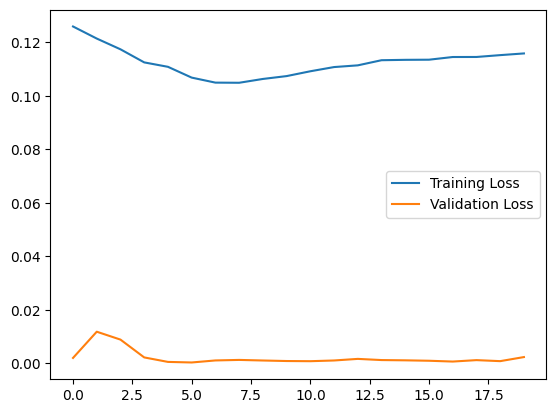

In [62]:
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.legend()

In [63]:
from tensorflow.keras.models import load_model

detector = load_model("/kaggle/working/detector.keras")
detector.evaluate(X_test, y_test)

743/743 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 1.0395


1.0337295532226562

743/743 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step
2972/2972 ━━━━━━━━━━━━━━━━━━━━ 69s 23ms/step
Confusion Matrix:
[[23755]]
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
F1-Score: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.



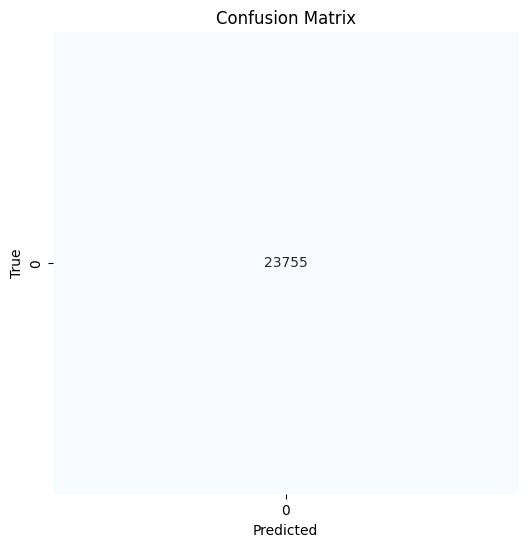

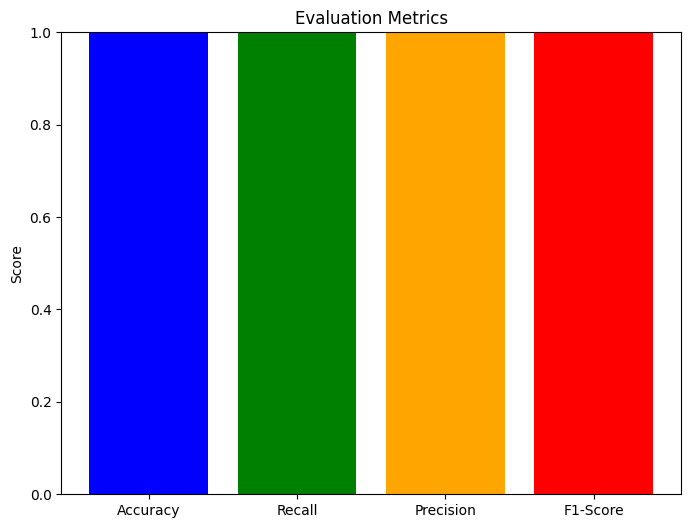

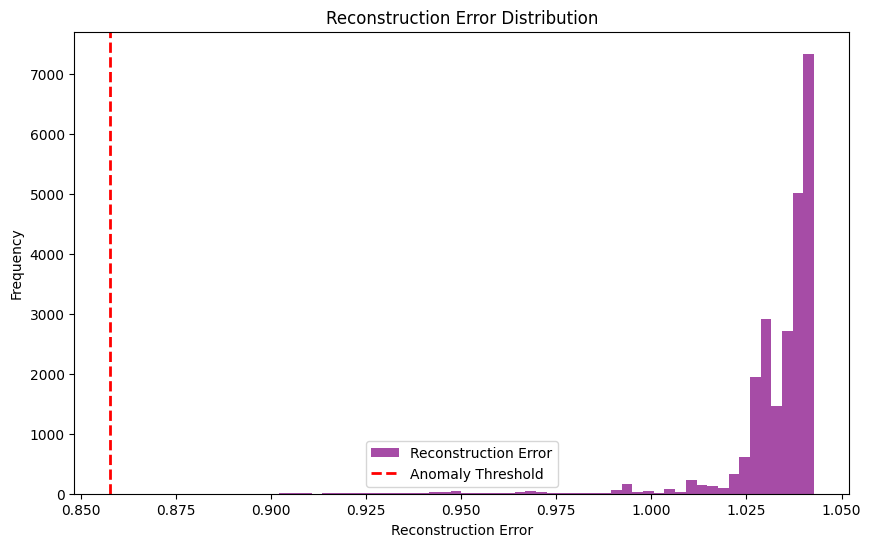

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X_test_pred = detector.predict(X_test)
reconstruction_errors = np.mean(np.abs(X_test - X_test_pred), axis=(1, 2))

threshold = np.percentile(np.mean(np.abs(X_train - detector.predict(X_train)), axis=(1, 2)), 95)

y_pred = (reconstruction_errors > threshold).astype(int)
y_test_binary = (np.mean(np.abs(X_test - X_test_pred), axis=(1, 2)) > threshold).astype(int)

cm = confusion_matrix(y_test_binary, y_pred)
accuracy = accuracy_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)

print("Confusion Matrix:")
print(cm)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-Score:", f1)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Plot evaluation metrics
metrics = [accuracy, recall, precision, f1]
labels = ["Accuracy", "Recall", "Precision", "F1-Score"]

plt.figure(figsize=(8, 6))
plt.bar(labels, metrics, color=['blue', 'green', 'orange', 'red'])
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Plot reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, color='purple', alpha=0.7, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label='Anomaly Threshold')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()


### Determining threshold for Autoencoder detector

2972/2972 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step


<ipython-input-65-3dd33a762e9a>:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

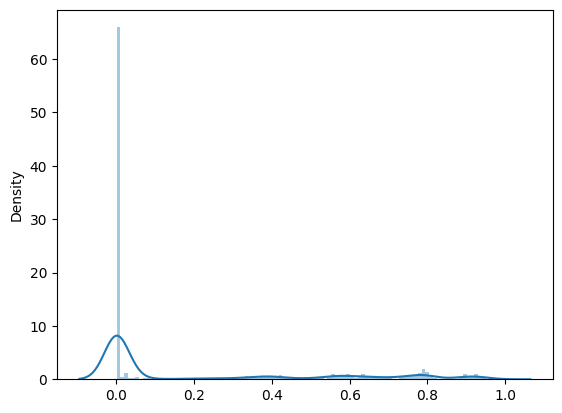

In [65]:
X_train_pred = detector.predict(X_train)
loss_mae = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.distplot(loss_mae, bins=100, kde=True)

In [ ]:
X_test_pred = detector.predict(X_test)
loss_mae = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(loss_mae, bins=100, kde=True)

In [67]:
threshold = 0.15

test_df = pd.DataFrame(test[tsteps:])
test_df['loss'] = loss_mae
test_df['threshold'] = threshold
test_df['anomaly'] = test_df.loss > test_df.threshold
test_df['Price'] = test[tsteps:].Price

### Plotting prices' anomalies

In [ ]:
anomalies = test_df[test_df.anomaly == True]
anomalies.head()

In [69]:
yvals1 = scaler.inverse_transform(test[tsteps:][['Price']])
yvals1 = yvals1.reshape(-1)

In [70]:
yvals2 = scaler.inverse_transform(anomalies[['Price']])
yvals2 = yvals2.reshape(-1)

In [71]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[tsteps:].index, y=yvals1,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=anomalies.index, y=yvals2,mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True,title="BTC price anomalies",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

In [72]:
import pandas as pd

scaled_pano = pd.concat([test, train], ignore_index=False) # Use pd.concat instead of append
X_shifted, y_shifted = shift_samples(scaled_pano[['Price']], scaled_pano.columns[0])
print("Scaled pano datasets' shapes:")
print('X_shifted: '+str(X_shifted.shape)+', y_shifted: '+str(y_shifted.shape))

Scaled pano datasets' shapes:
X_shifted: (118873, 24, 1), y_shifted: (118873, 1)


In [ ]:
X_shifted_pred = detector.predict(X_shifted)
loss_mae = np.mean(np.abs(X_shifted_pred - X_shifted), axis=1)

In [ ]:
non_scaled_pano = pano.copy()[51000:]
non_scaled_pano.fillna(method ='bfill', inplace = True)
non_scaled_pano = non_scaled_pano[:-24]

In [ ]:
loss_mae_series = pd.Series(loss_mae.flatten(), index=pd.RangeIndex(len(loss_mae)))
loss_mae_series = loss_mae_series.reindex(scaled_pano.index, fill_value=np.nan)
loss_mae_filtered = loss_mae_series[loss_mae_series.index.isin(non_scaled_pano.index)]
non_scaled_pano['loss_mae'] = loss_mae_filtered.values

non_scaled_pano['threshold'] = threshold
non_scaled_pano['anomaly'] = non_scaled_pano.loss_mae > non_scaled_pano.threshold
non_scaled_pano.head()

In [ ]:
pano_outliers = non_scaled_pano[non_scaled_pano['anomaly'] == True]

In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=non_scaled_pano.index, y=non_scaled_pano['Price'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=pano_outliers.index, y=pano_outliers['Price'].values,mode='markers',name='Anomaly'))
fig.update_layout(showlegend=True,title="BTC price anomalies - Autoencoder",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

##Isolation forest model

In [ ]:

outliers = pano.copy()[51000:]
outliers['Price'].fillna(method='bfill', inplace=True)
outliers['Price'].fillna(method='ffill', inplace=True)  #
isolation_detector = IsolationForest(n_estimators=150, random_state=0, contamination='auto')
isolation_detector.fit(outliers['Price'].values.reshape(-1, 1))

In [ ]:
data_ready = np.linspace(outliers['Price'].min(), outliers['Price'].max(), len(outliers)).reshape(-1,1)
outlier = isolation_detector.predict(data_ready)

In [ ]:
outliers['outlier'] = outlier
outliers.head()

#Plotting prices' anomalies

In [81]:
a = outliers.loc[outliers['outlier'] == 1] #anomaly
fig = go.Figure()
fig.add_trace(go.Scatter(x=outliers['Price'].index, y=outliers['Price'].values,mode='lines',name='BTC Price'))
fig.add_trace(go.Scatter(x=a.index, y=a['Price'].values,mode='markers',name='Anomaly',marker_symbol='x',marker_size=2))
fig.update_layout(showlegend=True,title="BTC price anomalies - IsolationForest",xaxis_title="Time",yaxis_title="Prices",font=dict(family="Courier New, monospace"))
fig.show()

GAN BASED MODEL

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scale the transaction data
data = pd.read_csv('/content/Bitcoin History.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
if 'Price' not in numerical_features:
    numerical_features.append('Price')

data_to_scale = data[numerical_features]
data_to_scale = data_to_scale.fillna(0)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_scale)
data_scaled = data_scaled.astype(np.float32)

In [3]:
# Define the Generator model architecture
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)
input_dim = 10
output_dim = data_scaled.shape[1]
generator = Generator(input_dim, output_dim)

generated_data = generator(torch.randn(data_scaled.shape[0], input_dim)).detach().numpy()
reconstruction_error = np.mean((data_scaled - generated_data)**2, axis=1)
threshold = np.percentile(reconstruction_error, 95)

data['anomaly'] = reconstruction_error > threshold
anomalies = data[data['anomaly'] == True]
print("Detected Anomalies using GAN:", anomalies)

Detected Anomalies using GAN:            Date  Price     Open     High    Low     Vol. Change %  anomaly
2511 2017-03-26  969.4    966.3  1,004.3  946.7   85.33K    0.32%     True
2512 2017-03-25  966.3    939.7    996.0  890.4  127.05K    2.83%     True
2513 2017-03-24  939.7  1,035.0  1,038.4  927.3  132.60K   -9.21%     True
2519 2017-03-18  971.4  1,071.7  1,103.6  940.2  210.42K   -9.36%     True
2552 2017-02-13  995.4    996.5  1,007.6  975.1   32.91K   -0.12%     True
...         ...    ...      ...      ...    ...      ...      ...      ...
3731 2013-11-22  802.0    764.9    822.0  682.3   30.15K    4.85%     True
3732 2013-11-21  764.9    638.0    784.3  595.2   38.73K   19.90%     True
3733 2013-11-20  638.0    645.7    650.0  453.3   91.59K   -1.20%     True
3734 2013-11-19  645.7    785.4    900.9  502.6   99.10K  -17.79%     True
3735 2013-11-18  785.4    528.3    787.9  522.0   72.07K   48.67%     True

[248 rows x 8 columns]


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

data = pd.read_csv('/content/Bitcoin History.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

numerical_features = data.select_dtypes(include=np.number).columns.tolist()
if 'Price' not in numerical_features:
    numerical_features.append('Price')

data_to_scale = data[numerical_features]
data_to_scale = data_to_scale.fillna(0)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_to_scale)
data_scaled = data_scaled.astype(np.float32)

X = data_scaled[:, :-1]  #
y = data_scaled[:, -1]
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).view(-1, 1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).view(-1, 1)

epochs = 100
for epoch in range(epochs):
    model.train()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

# Evaluate the model using different metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Epoch [0/100], Loss: 0.1206
Epoch [10/100], Loss: 0.1035
Epoch [20/100], Loss: 0.0893
Epoch [30/100], Loss: 0.0781
Epoch [40/100], Loss: 0.0698
Epoch [50/100], Loss: 0.0642
Epoch [60/100], Loss: 0.0610
Epoch [70/100], Loss: 0.0593
Epoch [80/100], Loss: 0.0587
Epoch [90/100], Loss: 0.0585
Mean Squared Error: 0.0199
Mean Absolute Error: 0.1406
R2 Score: -119.5680


Confusion Matrix:
 [[  0 503]
 [  0 488]]
Accuracy: 0.4924318869828456
Recall: 1.0
Precision: 0.4924318869828456
F1 Score: 0.6599053414469236


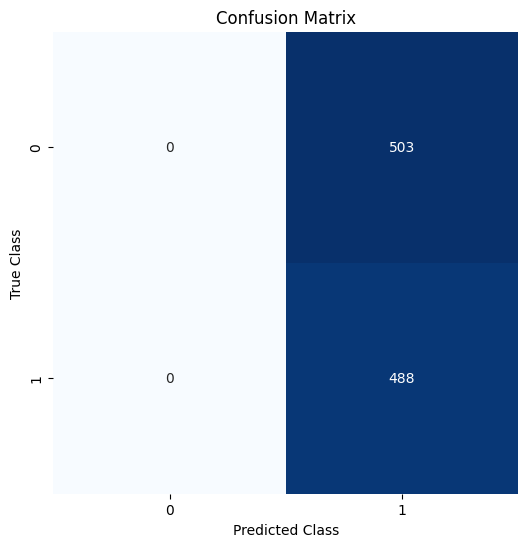

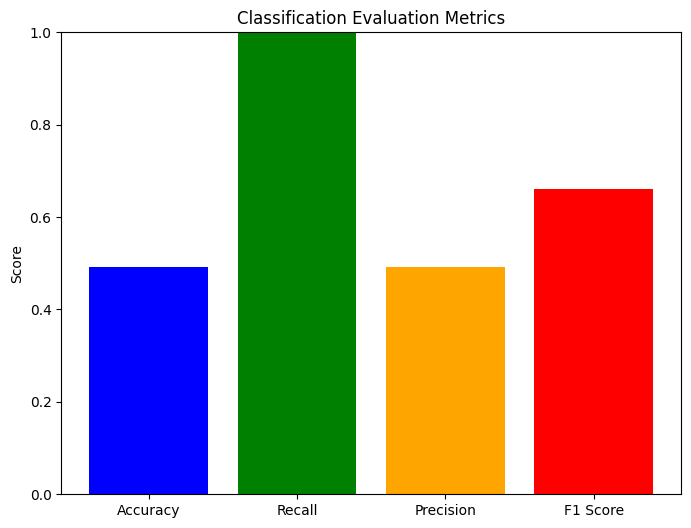

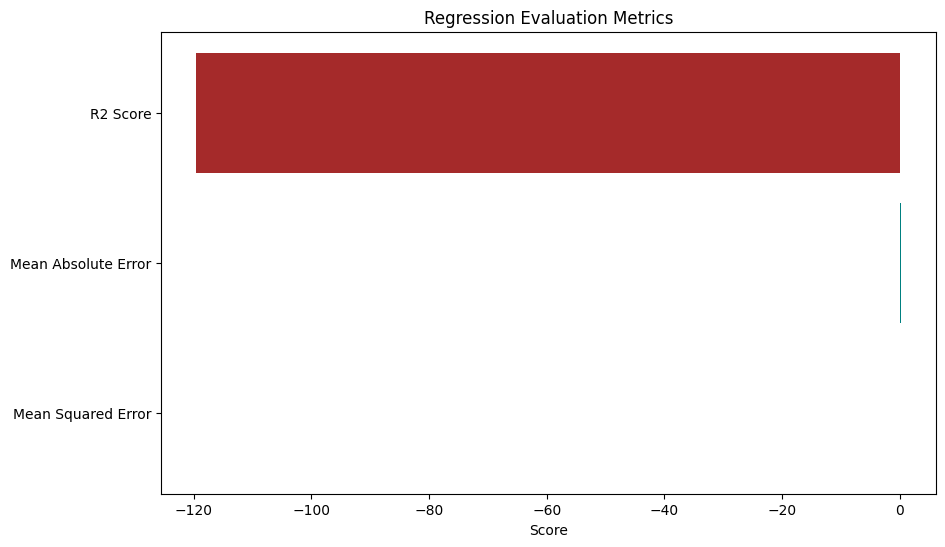

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

threshold = np.median(y_test)
y_test_class = (y_test > threshold).astype(int)
predictions_class = (predictions.flatten() > threshold).astype(int)

cm = confusion_matrix(y_test_class, predictions_class)
accuracy = accuracy_score(y_test_class, predictions_class)
recall = recall_score(y_test_class, predictions_class)
precision = precision_score(y_test_class, predictions_class)
f1 = f1_score(y_test_class, predictions_class)

# Print classification metrics
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# Plot evaluation metrics as a bar chart
metrics = [accuracy, recall, precision, f1]
labels = ["Accuracy", "Recall", "Precision", "F1 Score"]
plt.figure(figsize=(8, 6))
plt.bar(labels, metrics, color=['blue', 'green', 'orange', 'red'])
plt.title("Classification Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Plot regression evaluation metrics
plt.figure(figsize=(10, 6))
regression_metrics = [mse, mae, r2]
regression_labels = ["Mean Squared Error", "Mean Absolute Error", "R2 Score"]
plt.barh(regression_labels, regression_metrics, color=['purple', 'teal', 'brown'])
plt.title("Regression Evaluation Metrics")
plt.xlabel("Score")
plt.show()
